# Mixture Density Networks

## Part 1: Inverse Problem Data Generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [156]:
# set seed to ensure reproducibility
np.random.seed(42)

n = 512
x = np.sort(np.random.uniform(0, 1, size=(n,)))

#### Generate Target Data (Considering Forward Problem)

$$
t = x_n + 0.3 sin(2\pi x_n) + e \\
$$
$$
e \sim \text{Uniform}(-0.1, 0.1)
$$

In [157]:
t = x + 0.3 * np.sin(2 * np.pi * x) + np.random.uniform(-0.1, 0.1, size=(n,))

#### Plot Forward Problem Data

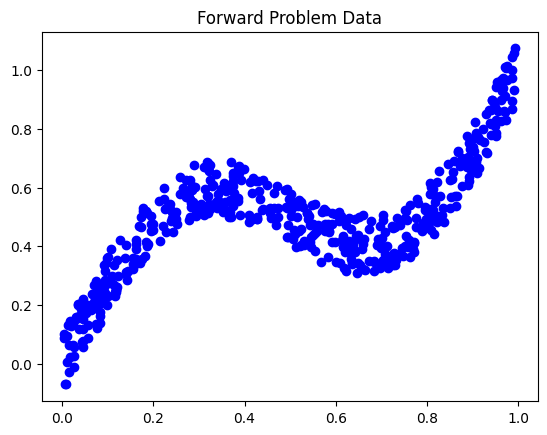

In [158]:
plt.plot(x, t, 'bo')
plt.title('Forward Problem Data')
plt.show()

#### Plot Inverse Problem Data

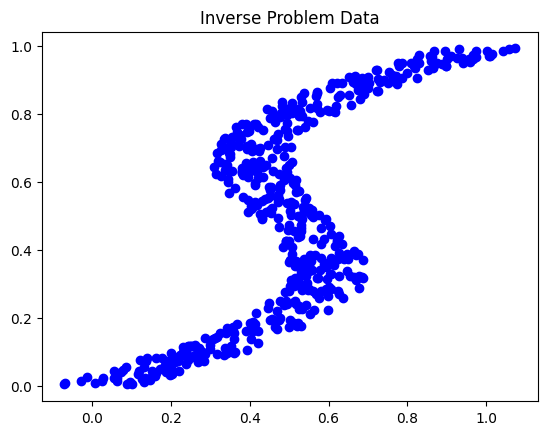

In [159]:
# on swapping t and x
plt.plot(t, x, 'bo')
plt.title('Inverse Problem Data')
plt.show()

## Part 2: Least Squares for both Forward and Inverse Data

#### Create DataLoader

In [165]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# we want input to be shaped like (n, 1), rows are samples, columns are features
batch_size=100
forward_dl = DataLoader(TensorDataset(torch.Tensor(x).view(-1, 1), torch.Tensor(t)), batch_size=batch_size, shuffle=True)
inverse_dl = DataLoader(TensorDataset(torch.Tensor(t).view(-1, 1), torch.Tensor(x)), batch_size=batch_size, shuffle=True)

# sanity check
assert next(iter(forward_dl))[0].shape == torch.Size([batch_size, 1])
assert next(iter(forward_dl))[1].shape == torch.Size([batch_size])

#### Create Network

In [166]:
import torch
import torch.nn as nn

In [167]:
class SimpleLinearRegression(nn.Module):
    '''Initializes Linear Regression Network'''
    def __init__(self, input_dim: int = 1, output_dim: int = 1, hidden_units: int = 100):
        super(SimpleLinearRegression, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_units), 
            nn.ReLU(),   # first hidden layer
            nn.Linear(hidden_units, hidden_units), 
            nn.ReLU(),   # second hidden layer
            nn.Linear(hidden_units, output_dim), # output layer,
        )
    
    def forward(self, x):
        return self.net(x).squeeze()

In [168]:
net = SimpleLinearRegression()

In [169]:
net

SimpleLinearRegression(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=1, bias=True)
  )
)

#### Create Training Pipeline

In [170]:
from torch.utils.data import DataLoader, TensorDataset

In [171]:
def fit(model, dl, optimizer, loss_fn, scheduler=None, epochs=10, evaluate=True):
    # set to training mode
    model.train()
    
    # check if scheduler passed
    is_scheduler = scheduler is not None
    
    # iterate over epochs and batches
    epoch_losses = []
    num_batches = len(dl)
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, batch in enumerate(dl):
            x, y = batch
            
            # compute loss
            loss = loss_fn(model(x), y)

            # backprop / optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if is_scheduler:
                scheduler.step()
            
            # update epoch_loss
            epoch_loss += loss.detach().item()
            
        # add to epoch_losses
        epoch_losses.append(epoch_loss / num_batches)
    
    if evaluate:
        # set to validation model
        model.eval()
        predictions = []
        x_vals = []

        # constructing datapoints to plot least-squares curve
        pred_dl = DataLoader(TensorDataset(torch.arange(0, 1, 0.0001).unsqueeze(1)), batch_size=100)
        with torch.no_grad(): # do not compute gradients while evaluating
            for batch_idx, batch in enumerate(pred_dl):
                x = batch[0]

                # storing so that plots can be made
                predictions.extend(model(x).tolist())
                x_vals.extend(x.squeeze().tolist())

        return x_vals, predictions, epoch_losses

    return epoch_losses

#### Fit Forward Problem Data

In [172]:
model = SimpleLinearRegression()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
epochs = 500
x_vals, predictions, epoch_losses = fit(
    model, 
    forward_dl,
    optimizer, 
    loss_fn=nn.MSELoss(),
    epochs=epochs
)

# plt.plot(np.arange(epochs), epoch_losses)
# plt.title('Epoch Loss')
# plt.show()

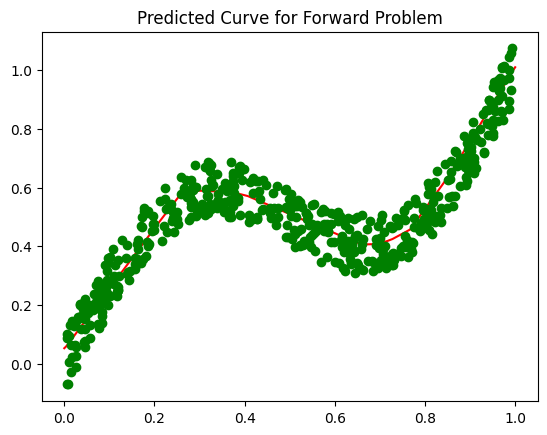

In [173]:
plt.plot(x_vals, predictions, 'r')
plt.plot(x, t, 'go')
plt.title('Predicted Curve for Forward Problem')
plt.show()

#### Fit Inverse Problem Data

In [174]:
model = SimpleLinearRegression(hidden_units=250) # have increased hidden_units to allow it to overfit
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
epochs = 500 # have added more epochs, to allow more time to overfit
x_vals, predictions, epoch_losses = fit(
    model, 
    inverse_dl,
    optimizer, 
    loss_fn=nn.MSELoss(),
    epochs=epochs
)

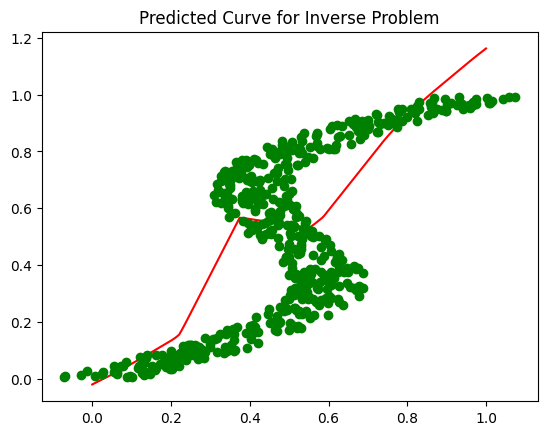

In [175]:
plt.plot(x_vals, predictions, 'r')
plt.plot(t, x, 'go')
plt.title('Predicted Curve for Inverse Problem')
plt.show()

## Part 3: Mixture Density Networks

In [176]:
class MixtureDensityNetwork(nn.Module):
    '''Initializes Linear Regression Network'''
    def __init__(self, input_dim: int = 1, components: int = 2, hidden_units: int = 100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_units), 
            nn.ReLU(),   # first hidden layer
            nn.Linear(hidden_units, hidden_units), 
            nn.ReLU(),   # second hidden layer
        )
        
        # layers for getting MDN outputs
        self.mean_net = nn.Linear(hidden_units, components)
        self.sigma_net = nn.Linear(hidden_units, components)
        self.mixing_net = nn.Linear(hidden_units, components)
    
    def forward(self, x):
        out = self.net(x) # (batch_size, hidden_units)
        
        # let's get mixing coefficients, mean and sigma
        log_pi = torch.log_softmax(self.mixing_net(out), dim=-1) # softmax over -1 dim
        mean = self.mean_net(out)
        sigma = torch.exp(self.sigma_net(out))
        
        return {
            'log_pi': log_pi, 
            'mean': mean, 
            'sigma': sigma
        }


### Writing the Negative Log Likelihood in Code
Let's write it in the form of equations. The likelihood per datapoint can be initially written as,

$$
p(t_n | x_n) = \sum_k \pi_k(x) \mathcal{N}(t_n | \mu_k(x), \sigma_k(x))
$$

If we write this as Negative Log Likelihood with neural network weights (w) generating mixing coefficients, $\mu$ and $\sigma$,

$$
\mathcal{L}(w) = -  \log\sum_k \pi_k(x) \mathcal{N}(t_n | \mu_k(x), \sigma_k(x))
$$

This log-sum can be further simplified with a log-sum-exp function that would be used for numerical stability. The log-sum-exp can be simply explained as follows

$$
\log \sum_i a_i b_i = \log \sum_i \exp \log (a_i b_i) = \log \sum_i \exp \left( \log (a_i) + \log(b_i)\right) = \text{logsumexp}(\log (a_i) + \log(b_i))
$$

So using this,

$$
\mathcal{L}(w) = - \text{logsumexp}(\log pi_k + \log ( \mathcal{N}(t_n | \mu_k(x), \sigma_k(x)) )
$$

Further simplification,

$$
\mathcal{L}(w) = - \text{logsumexp}(\log pi_k - 0.5 \log (\sigma_k(x)^2) - 0.5 \bigg(\frac{t_n - \mu_k(x)}{\sigma}\bigg)^2 )
$$


In [177]:
import math

def loss_mdn(y_pred, y_true):
    '''Computes NLL / Loss using y_true, mean, sigma and mixing_coeff
    
    Parameters
    ----------
    y_pred: dict containing
        log_pi: torch.Tensor
            Shape: (batch_size, components)
        mean: torch.Tensor
            Shape: (batch_size, components), mean for each component
        sigma: torch.Tensor
            Shape: (batch_size, components), std for each component
    y_true: torch.Tensor
        Shape: (batch_size, 1)
    
    Returns
    -------
    NegativeLogLikelikelihood or Loss: torch.Tensor
        Shape: (batch_size,)
    '''
    log_pi, mean, sigma = (
        y_pred['log_pi'], y_pred['mean'], y_pred['sigma']
    )

    # compute the z_score
    y_true = y_true.unsqueeze(1) # (batch_size) -> (batch_size, 1)
    normal_loglik = torch.log(sigma) - 0.5 * torch.pow((mean - y_true) / sigma, 2)
    
    # logsumexp(log pi + log likelihood) along components dimension
    nll = -torch.logsumexp(log_pi + normal_loglik, dim=1) 
    
    # if nll.mean() < 0:
    #     '''SHOULD NOT HAPPEN'''
    #     import ipdb; ipdb.set_trace()
    
    return nll.mean() # to return a single value for a batch

In [196]:
model = MixtureDensityNetwork(components=10, hidden_units=20)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
epochs = 50
iterations = epochs * len(inverse_dl)

# fit the model: Weird bit is that loss goes below zero
epoch_losses = fit(
    model, 
    inverse_dl,
    optimizer, 
    loss_fn=loss_mdn,
    epochs=epochs,
    evaluate=False
)


#### Let's visualize the samples

In [197]:
eval_x = torch.arange(0, 1, 0.0001).unsqueeze(1)
eval_x.shape

torch.Size([10000, 1])

In [198]:
def sample(model, x, samples=10):
    model.eval()
    with torch.no_grad():
        y_pred = model.forward(x)
        
    log_pi, mean, sigma = (
        y_pred['log_pi'], y_pred['mean'], y_pred['sigma']
    )                
    # compute cumulative sums using pi
    cum_pi = torch.cumsum(torch.exp(log_pi), dim=-1)
    rvs = torch.rand(len(x), 1).to(x)
    rand_pi = torch.searchsorted(cum_pi, rvs)
    # reparametrization
    rand_normal = torch.randn_like(mean) * sigma + mean
    samples = torch.gather(rand_normal, index=rand_pi, dim=1).squeeze()
    return samples

In [199]:
model.eval()
with torch.no_grad():
    eval_t =sample(model, eval_x)

In [203]:
def plot_data(x, y):
    plt.hist2d(x, y, bins=100)


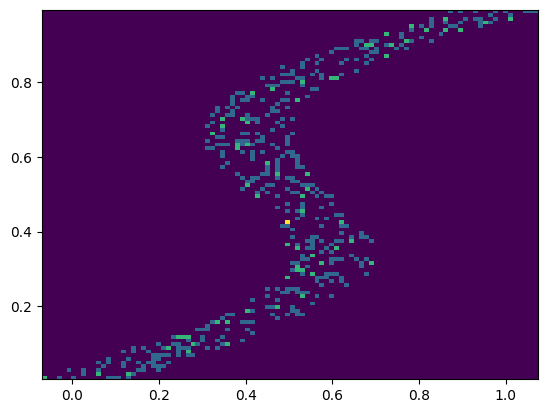

In [204]:
plot_data(t, x)

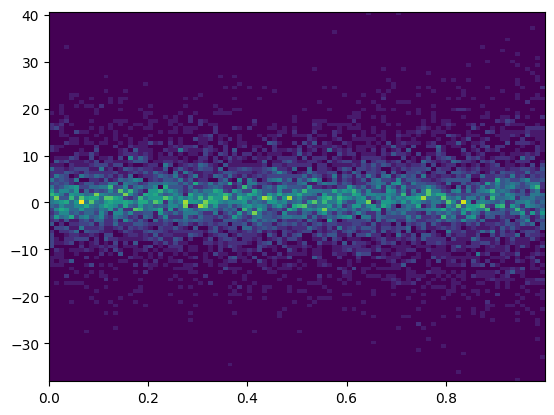

In [205]:
plot_data(eval_x.squeeze().numpy(), eval_t.numpy())